<a href="https://colab.research.google.com/github/AliMdRamjan/Hello-world/blob/main/PyEmma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import mdshare
import pyemma
from pyemma.util.contexts import settings

In [ ]:
pdb = mdshare.fetch('pentapeptide-impl-solv.pdb', working_directory='data')
files = mdshare.fetch('pentapeptide-*-500ns-impl-solv.xtc', working_directory='data')

In [ ]:
print(pdb)
print(files)

data\pentapeptide-impl-solv.pdb
['data\\pentapeptide-00-500ns-impl-solv.xtc', 'data\\pentapeptide-01-500ns-impl-solv.xtc', 'data\\pentapeptide-02-500ns-impl-solv.xtc', 'data\\pentapeptide-03-500ns-impl-solv.xtc', 'data\\pentapeptide-04-500ns-impl-solv.xtc', 'data\\pentapeptide-05-500ns-impl-solv.xtc', 'data\\pentapeptide-06-500ns-impl-solv.xtc', 'data\\pentapeptide-07-500ns-impl-solv.xtc', 'data\\pentapeptide-08-500ns-impl-solv.xtc', 'data\\pentapeptide-09-500ns-impl-solv.xtc', 'data\\pentapeptide-10-500ns-impl-solv.xtc', 'data\\pentapeptide-11-500ns-impl-solv.xtc', 'data\\pentapeptide-12-500ns-impl-solv.xtc', 'data\\pentapeptide-13-500ns-impl-solv.xtc', 'data\\pentapeptide-14-500ns-impl-solv.xtc', 'data\\pentapeptide-15-500ns-impl-solv.xtc', 'data\\pentapeptide-16-500ns-impl-solv.xtc', 'data\\pentapeptide-17-500ns-impl-solv.xtc', 'data\\pentapeptide-18-500ns-impl-solv.xtc', 'data\\pentapeptide-19-500ns-impl-solv.xtc', 'data\\pentapeptide-20-500ns-impl-solv.xtc', 'data\\pentapeptide-21

In [ ]:
torsions_feat = pyemma.coordinates.featurizer(pdb)
torsions_feat.add_backbone_torsions(cossin=True, periodic=False)
torsions_data = pyemma.coordinates.load(files, features=torsions_feat)
labels = ['backbone\ntorsions']

positions_feat = pyemma.coordinates.featurizer(pdb)
positions_feat.add_selection(positions_feat.select_Backbone())
positions_data = pyemma.coordinates.load(files, features=positions_feat)
labels += ['backbone atom\npositions']

distances_feat = pyemma.coordinates.featurizer(pdb)
distances_feat.add_distances(
    distances_feat.pairs(distances_feat.select_Backbone(), excluded_neighbors=2), periodic=False)
distances_data = pyemma.coordinates.load(files, features=distances_feat)
labels += ['backbone atom\ndistances']

Obtaining file info:   0%|                                                                      | 0/25 [00:00<…

getting output of FeatureReader:   0%|                                                          | 0/25 [00:00<…

Obtaining file info:   0%|                                                                      | 0/25 [00:00<…

getting output of FeatureReader:   0%|                                                          | 0/25 [00:00<…

Obtaining file info:   0%|                                                                      | 0/25 [00:00<…

getting output of FeatureReader:   0%|                                                          | 0/25 [00:00<…

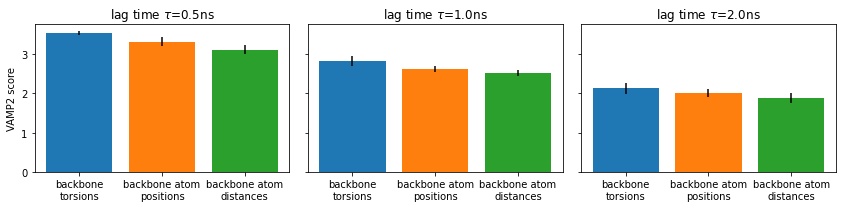

In [ ]:
def score_cv(data, dim, lag, number_of_splits=10, validation_fraction=0.5):
    """Compute a cross-validated VAMP2 score.

    We randomly split the list of independent trajectories into
    a training and a validation set, compute the VAMP2 score,
    and repeat this process several times.

    Parameters
    ----------
    data : list of numpy.ndarrays
        The input data.
    dim : int
        Number of processes to score; equivalent to the dimension
        after projecting the data with VAMP2.
    lag : int
        Lag time for the VAMP2 scoring.
    number_of_splits : int, optional, default=10
        How often do we repeat the splitting and score calculation.
    validation_fraction : int, optional, default=0.5
        Fraction of trajectories which should go into the validation
        set during a split.
    """
    # we temporarily suppress very short-lived progress bars
    with pyemma.util.contexts.settings(show_progress_bars=False):
        nval = int(len(data) * validation_fraction)
        scores = np.zeros(number_of_splits)
        for n in range(number_of_splits):
            ival = np.random.choice(len(data), size=nval, replace=False)
            vamp = pyemma.coordinates.vamp(
                [d for i, d in enumerate(data) if i not in ival], lag=lag, dim=dim)
            scores[n] = vamp.score([d for i, d in enumerate(data) if i in ival])
    return scores


dim = 10

fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True)
for ax, lag in zip(axes.flat, [5, 10, 20]):
    torsions_scores = score_cv(torsions_data, lag=lag, dim=dim)
    scores = [torsions_scores.mean()]
    errors = [torsions_scores.std()]
    positions_scores = score_cv(positions_data, lag=lag, dim=dim)
    scores += [positions_scores.mean()]
    errors += [positions_scores.std()]
    distances_scores = score_cv(distances_data, lag=lag, dim=dim)
    scores += [distances_scores.mean()]
    errors += [distances_scores.std()]
    ax.bar(labels, scores, yerr=errors, color=['C0', 'C1', 'C2'])
    ax.set_title(r'lag time $\tau$={:.1f}ns'.format(lag * 0.1))
    if lag == 5:
        # save for later
        vamp_bars_plot = dict(
            labels=labels, scores=scores, errors=errors, dim=dim, lag=lag)
axes[0].set_ylabel('VAMP2 score')
fig.tight_layout()

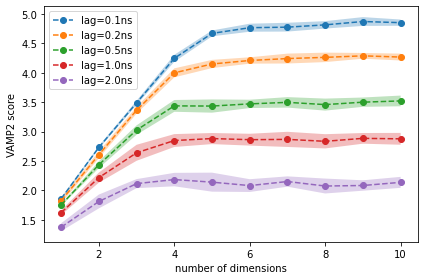

In [ ]:
lags = [1, 2, 5, 10, 20]
dims = [i + 1 for i in range(10)]

fig, ax = plt.subplots()
for i, lag in enumerate(lags):
    scores_ = np.array([score_cv(torsions_data, dim, lag)
                        for dim in dims])
    scores = np.mean(scores_, axis=1)
    errors = np.std(scores_, axis=1, ddof=1)
    color = 'C{}'.format(i)
    ax.fill_between(dims, scores - errors, scores + errors, alpha=0.3, facecolor=color)
    ax.plot(dims, scores, '--o', color=color, label='lag={:.1f}ns'.format(lag * 0.1))
ax.legend()
ax.set_xlabel('number of dimensions')
ax.set_ylabel('VAMP2 score')
fig.tight_layout()